# Data Pre-Processing and Model Training

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
import statsmodels.api as sm
from scipy.stats import norm

# Load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Select a single target column for analysis
target_column = 'CHSI2_48H__0'

# Filter features to include only those starting with "CH"
ch_features = [col for col in train_data.columns if col.startswith('CH') and col != target_column]
X = train_data[ch_features]
y = train_data[target_column]

# Fill missing values
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions on validation set
y_pred = model.predict(X_val_scaled)

# RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE for {target_column}: {rmse:.2f}")

<ipython-input-1-cdfa0fd6afe4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


RMSE for CHSI2_48H__0: 6.37


# Actual vs Predicted Scatter and Residual Plot

In [2]:
# Plot: Actual vs Predicted Scatter
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_val, y=y_pred, mode='markers',line=dict(color='blue'), name='Predictions', opacity=0.3))
fig.add_trace(go.Scatter(x=[y_val.min(), y_val.max()], y=[y_val.min(), y_val.max()], mode='lines', name='Ideal', line=dict(color='red', dash='dash')))
fig.update_layout(title=f"{target_column} (RMSE: {rmse:.2f})", xaxis_title="Actual Flow", yaxis_title="Predicted Flow")
fig.show()

# Residual Plot
residuals = y_val - y_pred
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_pred, y=residuals, mode='markers', name='Residuals',line=dict(color='blue'), opacity=0.3))
fig.add_trace(go.Scatter(x=[y_pred.min(), y_pred.max()], y=[0, 0], mode='lines', name='Zero Line', line=dict(color='red', dash='dash')))
fig.update_layout(title="Residual Plot", xaxis_title="Predicted", yaxis_title="Residuals")
fig.show()


# Feature Importance for CH variables and peak flow events, Classification Report

In [3]:
# Feature Importance for CH variables
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
fig = go.Figure()
fig.add_trace(go.Bar(x=np.array(ch_features)[indices], y=importances[indices]))
fig.update_layout(title="Feature Importances (CH Variables)", xaxis_title="Feature", yaxis_title="Importance")
fig.show()


# Detect peak flow events
peak_threshold = y_val.mean() + 2 * y_val.std()  #threshold
peak_events = (y_val > peak_threshold).astype(int)
print(peak_threshold)
# Classify events and assess classification metrics
y_pred_class = (y_pred > peak_threshold).astype(int)
print(f"Classification Report for {target_column}:")
print(classification_report(peak_events, y_pred_class))
print("Confusion Matrix:")
print(confusion_matrix(peak_events, y_pred_class))



292.46272556930046
Classification Report for CHSI2_48H__0:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1286
           1       1.00      0.86      0.92        83

    accuracy                           0.99      1369
   macro avg       1.00      0.93      0.96      1369
weighted avg       0.99      0.99      0.99      1369

Confusion Matrix:
[[1286    0]
 [  12   71]]


# Hydrograph, Flow Duration Curve , Extreme Value Analysis

In [4]:
# Hydrograph
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(y_val)), y=y_val, mode='lines', name='Actual', line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(x=np.arange(len(y_pred)), y=y_pred, mode='lines', name='Predicted', line=dict(color='red', width=1)))
fig.update_layout(title="Hydrograph", xaxis_title="Time Step", yaxis_title="Flow")
fig.show()

# Flow Duration Curve
sorted_flows = np.sort(y_val)
exceedance_probability = np.arange(1., len(sorted_flows) + 1) / len(sorted_flows)
fig = go.Figure()
fig.add_trace(go.Scatter(x=exceedance_probability, y=sorted_flows, mode='lines', name='Flow Duration Curve'))
fig.update_layout(title="Flow Duration Curve", xaxis_title="Exceedance Probability", yaxis_title="Flow", xaxis_type="log", yaxis_type="log")
fig.show()

# Flood Analysis (Example: Extreme Value Analysis)
extreme_flows = y_val[y_val > peak_threshold]
fit = norm.fit(extreme_flows)
x = np.linspace(extreme_flows.min(), extreme_flows.max(), 100)
pdf_fitted = norm.pdf(x, loc=fit[0], scale=fit[1])
fig = go.Figure()
fig.add_trace(go.Histogram(x=extreme_flows, nbinsx=30, histnorm='probability density', name='Extreme Flows', opacity=0.6))
fig.add_trace(go.Scatter(x=x, y=pdf_fitted, mode='lines', name='Fitted PDF', line=dict(color='red')))
fig.update_layout(title="Extreme Value Analysis", xaxis_title="Flow", yaxis_title="Density")
fig.show()

In [7]:
import pandas as pd
import numpy as np

# Load your dataset
train_data = pd.read_csv("train.csv")

# Select the target column for analysis
target_column = 'CHSI2_48H__0'
flow_data = train_data[target_column]

# Calculate mean and median flow
mean_flow = flow_data.mean()
median_flow = flow_data.median()

# Calculate flow variability (standard deviation and coefficient of variation)
flow_std = flow_data.std()
flow_cv = flow_std / mean_flow

# Find peak and low flow
peak_flow = flow_data.max()
low_flow = flow_data.min()

# Calculate percentiles for Flow Duration Curve
q10 = np.percentile(flow_data, 90)
q50 = np.percentile(flow_data, 50)
q90 = np.percentile(flow_data, 10)

# Print the calculated values
print(f"Mean Flow: {mean_flow:.2f}")
print(f"Median Flow: {median_flow:.2f}")
print(f"Flow Variability (Standard Deviation): {flow_std:.2f}")
print(f"Flow Variability (Coefficient of Variation): {flow_cv:.2f}")
print(f"Peak Flow: {peak_flow:.2f}")
print(f"Low Flow: {low_flow:.2f}")
print(f"Q10 (90th Percentile): {q10:.2f}")
print(f"Q50 (50th Percentile): {q50:.2f}")
print(f"Q90 (10th Percentile): {q90:.2f}")

Mean Flow: 161.99
Median Flow: 151.00
Flow Variability (Standard Deviation): 60.95
Flow Variability (Coefficient of Variation): 0.38
Peak Flow: 350.00
Low Flow: 68.20
Q10 (90th Percentile): 253.00
Q50 (50th Percentile): 151.00
Q90 (10th Percentile): 89.70


In [8]:
import pandas as pd
import numpy as np

# Load your dataset
train_data = pd.read_csv("train.csv")

# Select the target column for analysis
target_column = 'CHSI2_48H__0'
flow_data = train_data[target_column].values

# Ensure no negative flows
flow_data = np.clip(flow_data, a_min=0, a_max=None)

# Baseflow separation using the Lyne-Hollick filter
alpha = 0.925  # Recession constant, adjust based on your watershed
baseflow = np.zeros(len(flow_data))
baseflow[0] = flow_data[0]  # Initial baseflow

for t in range(1, len(flow_data)):
    baseflow[t] = alpha * baseflow[t-1] + (1 - alpha) * flow_data[t]
    baseflow[t] = min(baseflow[t], flow_data[t])  # Ensure baseflow does not exceed total flow

# Calculate Baseflow Index
bfi = baseflow.sum() / flow_data.sum()

print(f"Baseflow Index (BFI): {bfi:.2f}")

Baseflow Index (BFI): 0.66


In [9]:
from scipy.stats import gumbel_r

# Fit a Gumbel distribution to the peak flows
peak_flows = flow_data[flow_data > flow_data.mean() + 2 * flow_data.std()]  # Example threshold
params = gumbel_r.fit(peak_flows)

# Calculate return period for a specific flow value
flow_value = peak_flows.max()  # Example: maximum observed flow
probability = gumbel_r.cdf(flow_value, *params)
return_period = 1 / (1 - probability)

print(f"Return Period for peak flow {flow_value:.2f}: {return_period:.2f} years")

Return Period for peak flow 350.00: 11.88 years


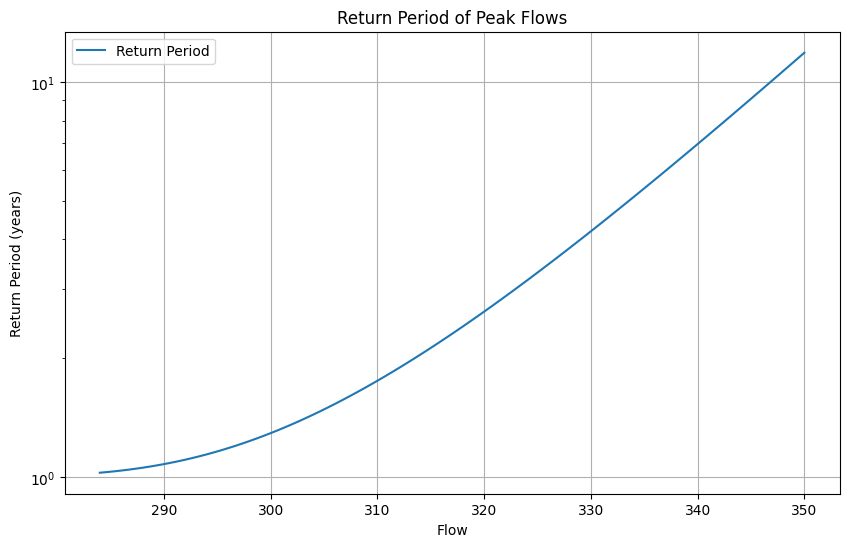

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r

# Identify peak flows (e.g., flows above a certain threshold)
threshold = flow_data.mean() + 2 * flow_data.std()  # Example threshold
peak_flows = flow_data[flow_data > threshold]

# Fit a Gumbel distribution to the peak flows
params = gumbel_r.fit(peak_flows)

# Generate flow values for plotting
flow_values = np.linspace(min(peak_flows), max(peak_flows), 100)
probabilities = gumbel_r.cdf(flow_values, *params)
return_periods = 1 / (1 - probabilities)

# Plot the return period
plt.figure(figsize=(10, 6))
plt.plot(flow_values, return_periods, label='Return Period')
plt.xlabel('Flow')
plt.ylabel('Return Period (years)')
plt.title('Return Period of Peak Flows')
plt.yscale('log')  # Log scale for return period
plt.grid(True)
plt.legend()
plt.show()